In [19]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Utils.recsys2022DataReader import *
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Evaluation.Evaluator import EvaluatorHoldout
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
URM = createURMBinary()

/Users/matteopancini/PycharmProjects/recsys-challenge-2022-Pancini-Vitali/Utils/recsys2022DataReader.py:54: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


In [3]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)

In [4]:
profile_length = np.ediff1d(URM.indptr)
sorted_users = np.argsort(profile_length)

In [5]:
block_size = int(len(profile_length) * 0.25)

In [6]:
interactions = []
for i in range(41629):
    interactions.append(len(URM[i,:].nonzero()[0]))

In [15]:
max(interactions)

414

<AxesSubplot:ylabel='Count'>

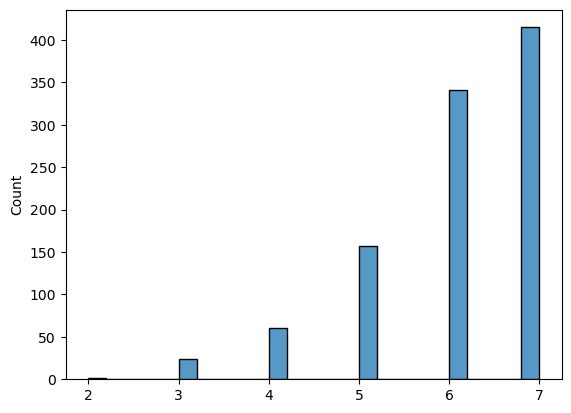

In [21]:
#interactions = np.array(inter).sort()
interactions_to_plot = sorted(interactions)[:1000]

sb.histplot(interactions_to_plot)

In [7]:
recommender_object_dict = {}

In [8]:
# RP3beta
RP3beta = RP3betaRecommender(URM_train)
RP3beta.fit(alpha=0.5126756776495514, beta=0.396119587486951, topK=100)
recommender_object_dict['RP3Beta'] = RP3beta

RP3betaRecommender: Similarity column 24507 (100.0%), 4378.23 column/sec. Elapsed time 5.60 sec


# Interactions

In [9]:
list_group_interactions = [[0, 20], [21, 25], [26, 49], [50, max(interactions)]]
MAP_recommender_per_group_int = {}

for group_id in range(0, 4):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions))
                      if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_int:
            MAP_recommender_per_group_int[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_int[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 22790, average p.len 13.79, median 14.0, min 2, max 20
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 18839 Users
EvaluatorHoldout: Processed 19891 (100.0%) in 8.10 sec. Users per second: 2457
Group 1, #users in group 5361, average p.len 22.82, median 23.0, min 21, max 25
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 36268 Users
EvaluatorHoldout: Processed 5235 (100.0%) in 2.83 sec. Users per second: 1847
Group 2, #users in group 9661, average p.len 34.57, median 33.0, min 26, max 49
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31968 Users
EvaluatorHoldout: Processed 9612 (100.0%) in 4.73 sec. Users per second: 2034
Group 3, #users in group 3817, average p.len 73.69, median 64.0, min 50, max 414
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 t

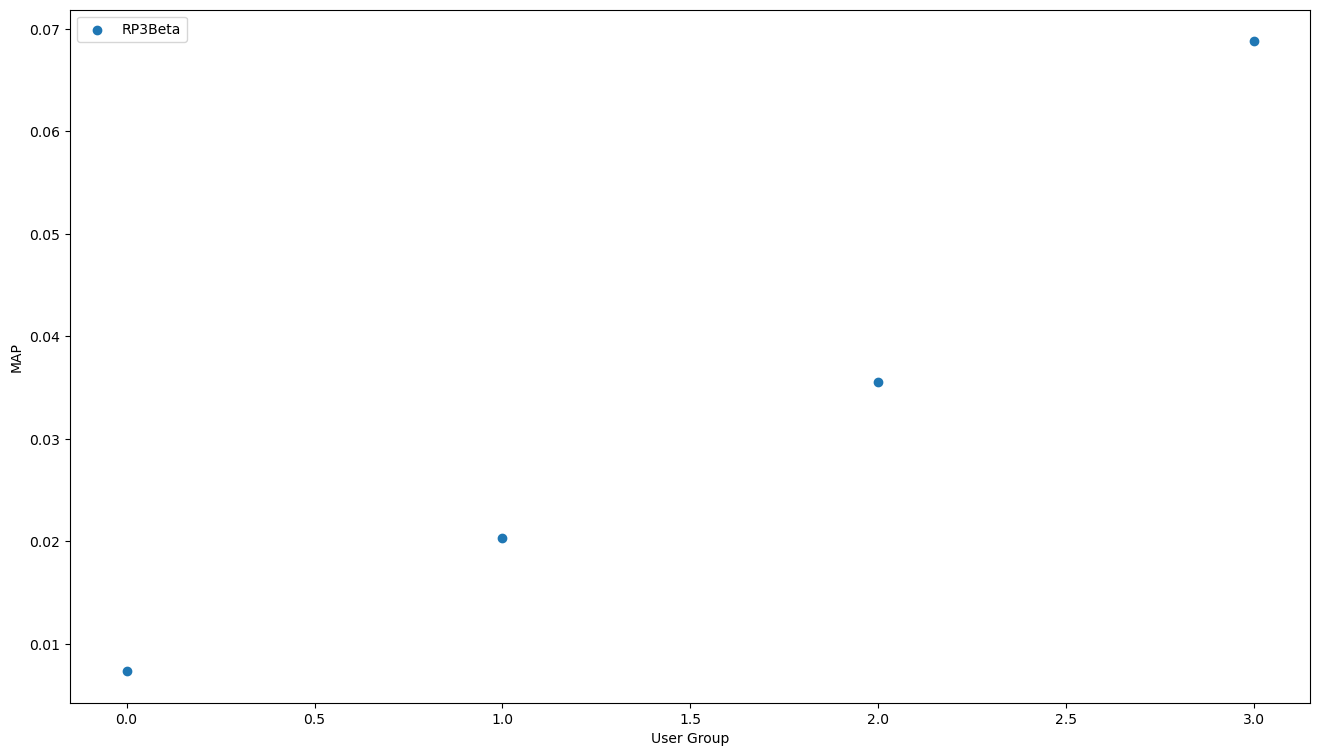

RP3Beta [0.007336815006866718, 0.02036804323767064, 0.03554971794516169, 0.06880112362821295]


In [10]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_int[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))

# 4 Blocks

In [11]:
MAP_recommender_per_group_block = {}

for group_id in range(0, 4):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_block:
            MAP_recommender_per_group_block[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_block[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 10407, average p.len 10.36, median 11.0, min 2, max 13
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
EvaluatorHoldout: Processed 8358 (100.0%) in 3.72 sec. Users per second: 2249
Group 1, #users in group 10407, average p.len 16.10, median 16.0, min 13, max 19
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
EvaluatorHoldout: Processed 9623 (100.0%) in 4.31 sec. Users per second: 2235
Group 2, #users in group 10407, average p.len 23.66, median 23.0, min 19, max 30
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
EvaluatorHoldout: Processed 10191 (100.0%) in 4.71 sec. Users per second: 2162
Group 3, #users in group 10407, average p.len 50.91, median 43.0, min 30, max 359
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 

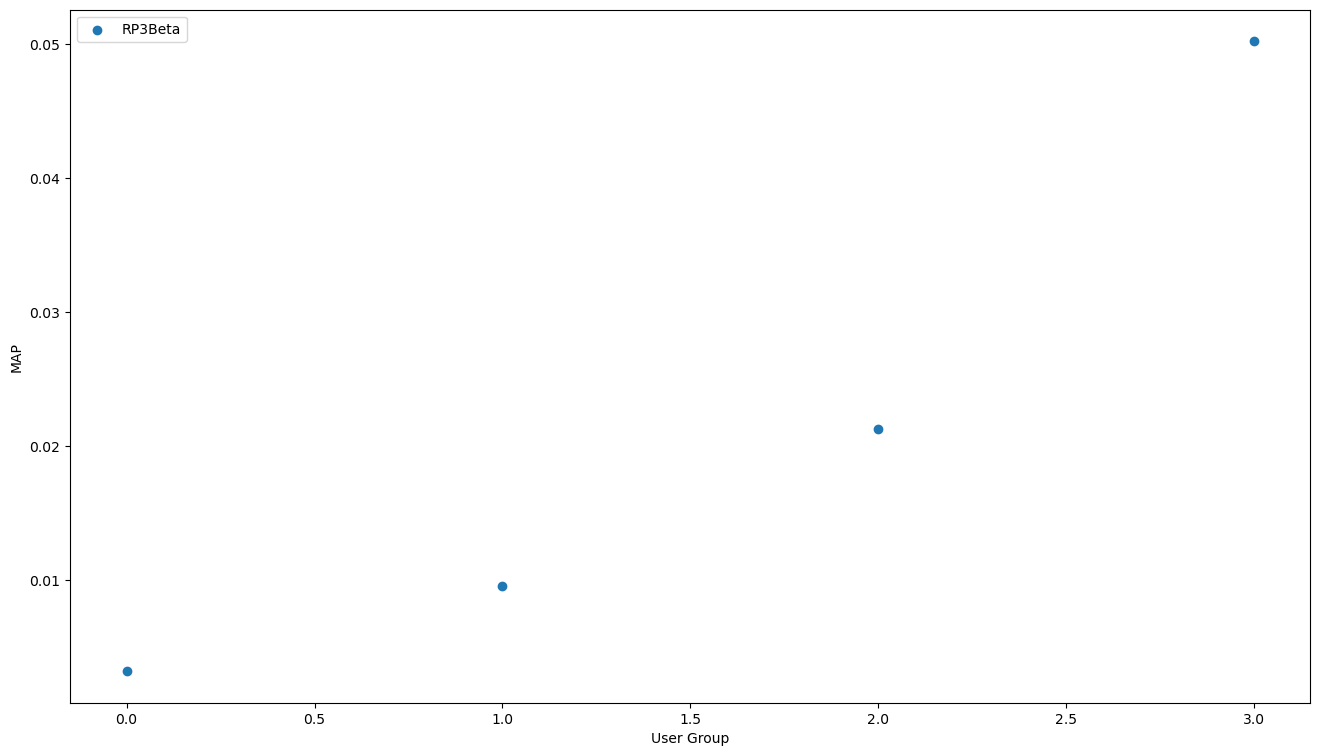

RP3Beta [0.0031804287879305996, 0.009559092056234267, 0.021289053677926217, 0.050215612797485945]


In [12]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_block[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))

# 5 blocks

In [13]:
MAP_recommender_per_group_block = {}
block_size = int(len(profile_length) * 0.2)

for group_id in range(0, 5):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_block:
            MAP_recommender_per_group_block[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_block[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 8325, average p.len 16.61, median 17.0, min 5, max 20
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33304 Users
EvaluatorHoldout: Processed 7709 (100.0%) in 5.05 sec. Users per second: 1528
Group 1, #users in group 8325, average p.len 22.66, median 23.0, min 20, max 25
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33304 Users
EvaluatorHoldout: Processed 8103 (100.0%) in 6.36 sec. Users per second: 1274
Group 2, #users in group 8325, average p.len 28.73, median 29.0, min 25, max 33
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33304 Users
EvaluatorHoldout: Processed 8250 (100.0%) in 5.60 sec. Users per second: 1473
Group 3, #users in group 8325, average p.len 38.92, median 38.0, min 33, max 47
EvaluatorHoldout: Ignoring 929 ( 2.2%) Users that have less than 1 test int

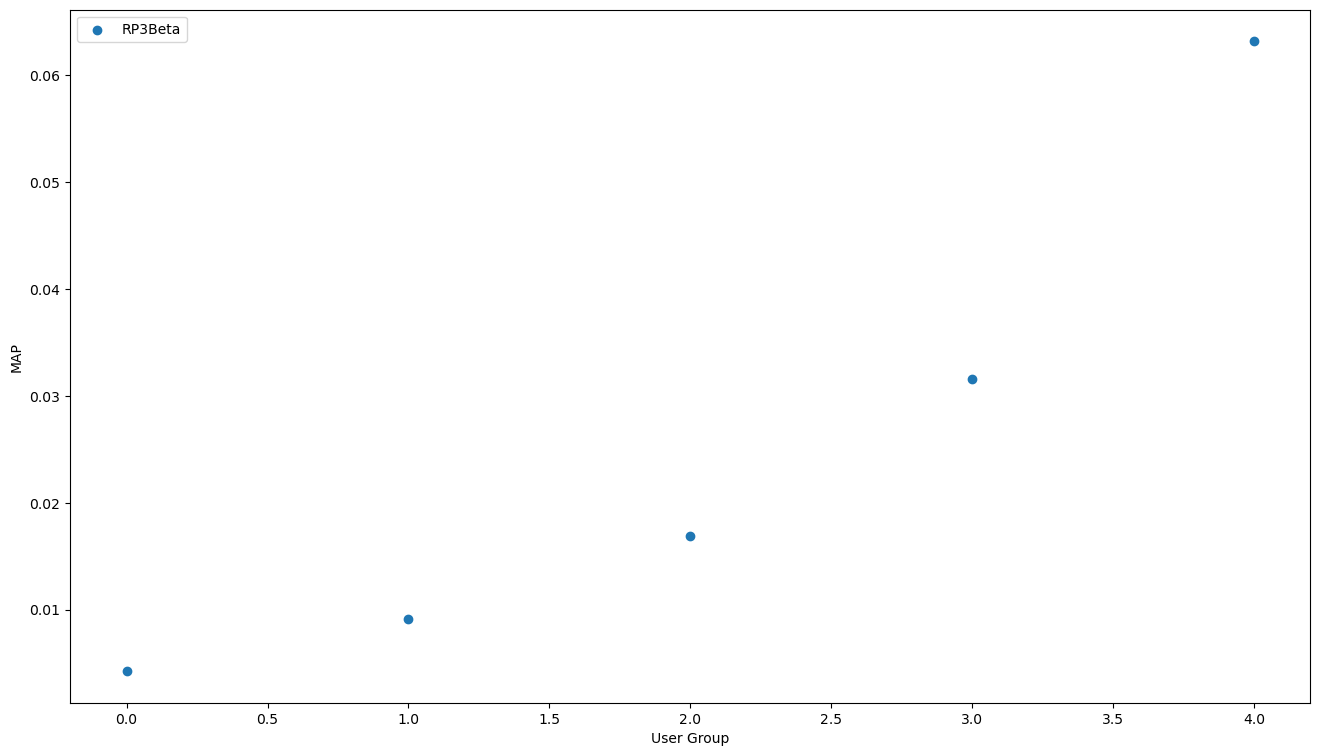

RP3Beta [0.004244502920725542, 0.009123291589044987, 0.016884521404521305, 0.031573308346084905, 0.06318031841365232]


In [14]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_block[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))

# Interactions 2

In [28]:
list_group_interactions = [[0, 19], [20, 49], [50, max(interactions)]]
MAP_recommender_per_group_int = {}

for group_id in range(0, 3):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions))
                      if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        len(users_in_group),
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group_int:
            MAP_recommender_per_group_int[label].append(result_df.loc[10]["MAP"])
        else:
            MAP_recommender_per_group_int[label] = [result_df.loc[10]["MAP"]]

Group 0, #users in group 21434, average p.len 13.40, median 14.0, min 2, max 19
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 20195 Users
EvaluatorHoldout: Processed 18578 (100.0%) in 7.48 sec. Users per second: 2484
Group 1, #users in group 16378, average p.len 29.52, median 28.0, min 20, max 49
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 25251 Users
EvaluatorHoldout: Processed 16160 (100.0%) in 7.22 sec. Users per second: 2238
Group 2, #users in group 3817, average p.len 73.69, median 64.0, min 50, max 414
EvaluatorHoldout: Ignoring 3074 ( 7.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 37812 Users
EvaluatorHoldout: Processed 3817 (100.0%) in 2.59 sec. Users per second: 1471


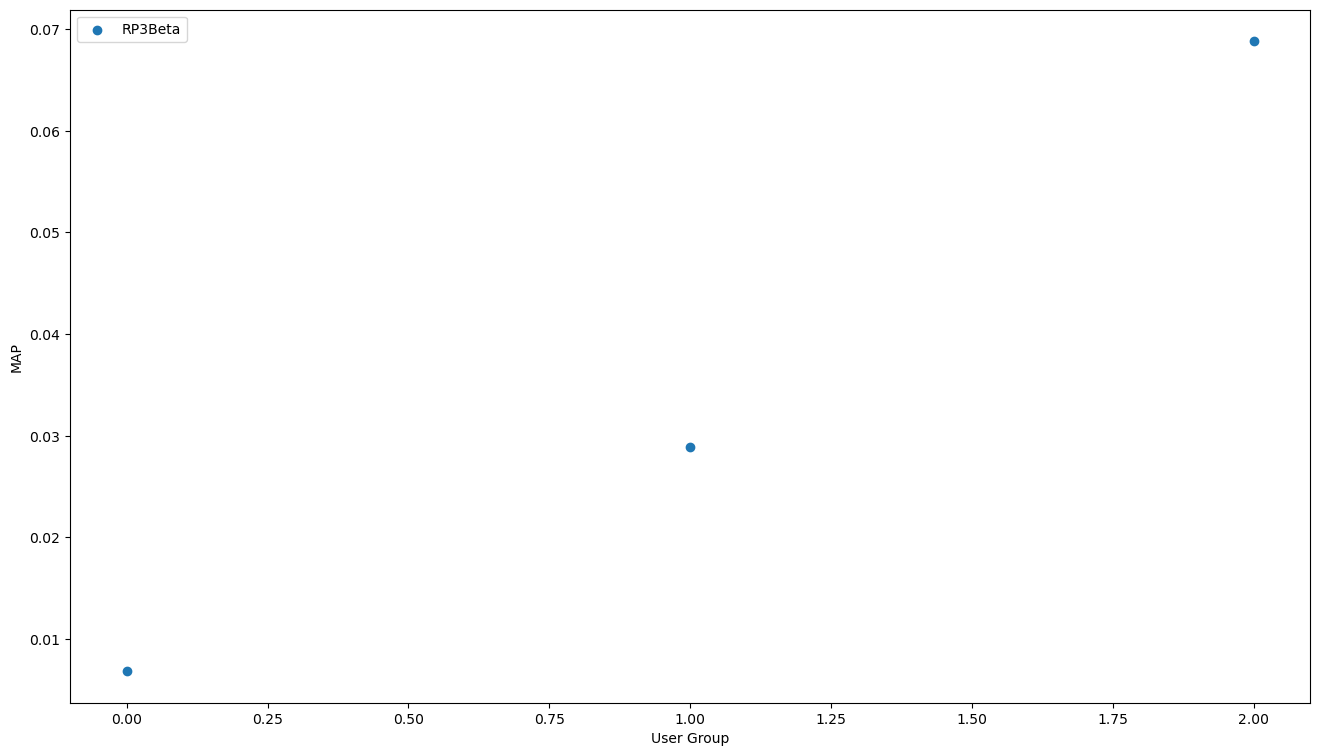

RP3Beta [0.0068495058158907106, 0.028899570760648183, 0.06880112362821295]


In [30]:
_ = plt.figure(figsize=(16, 9))

finalResults = {}

for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group_int[label]
    finalResults[label] = results
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

for label in finalResults:
    print(label + ' ' + str(finalResults[label]))